In [7]:
import yfinance as yf, numpy as np, pandas as pd, random, tqdm
import pandas_ta as pta
import quantstats as qs
import requests
from requests_html import HTMLSession

In [8]:
start = '2021-01-01'
end = '2021-12-01'

In [9]:
%%time

sp500 = list(pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol)
sp500 = [e.replace('.','-') for e in sp500]
cryptos = pd.read_html(HTMLSession().get(f"https://finance.yahoo.com/crypto?offset=0&count=25").html.raw_html)[0].Symbol.tolist()

data = yf.download(cryptos, start=start, end=end)['Adj Close']

benchmark = data.pct_change().mean(axis=1) # Para atenuar el sesgo de selección, en vez de tomar al SPY real,
                                                    # como benchmark se toma al promedio de los activos disponibles.
benchmark.replace([np.inf, -np.inf], np.nan, inplace=True)
benchmark = benchmark.dropna()

data = pd.melt(data.reset_index(), id_vars='Date')
data.columns = ['Date', 'Ticker', 'Close']
data['pct_change'] = np.where(data['Ticker'] == data['Ticker'].shift(1), data['Close'].pct_change(), np.nan)
data["rsi"] = pta.rsi(data['Close'], length = 14)
data["rsi_ayer"] = np.where(data['Ticker'] == data['Ticker'].shift(1), data['rsi'].shift(1), np.nan)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data[data['pct_change'] != 0].dropna()


[*********************100%***********************]  25 of 25 completed

1 Failed download:
- WTRX-USD: Data doesn't exist for startDate = 1609470000, endDate = 1638327600
Wall time: 9.86 s


In [10]:
strategy = data.loc[data.groupby('Date').rsi_ayer.idxmin()].iloc[1:, :][['Date', 'Ticker', 'pct_change']].reset_index(drop=True)

<AxesSubplot:xlabel='Date'>

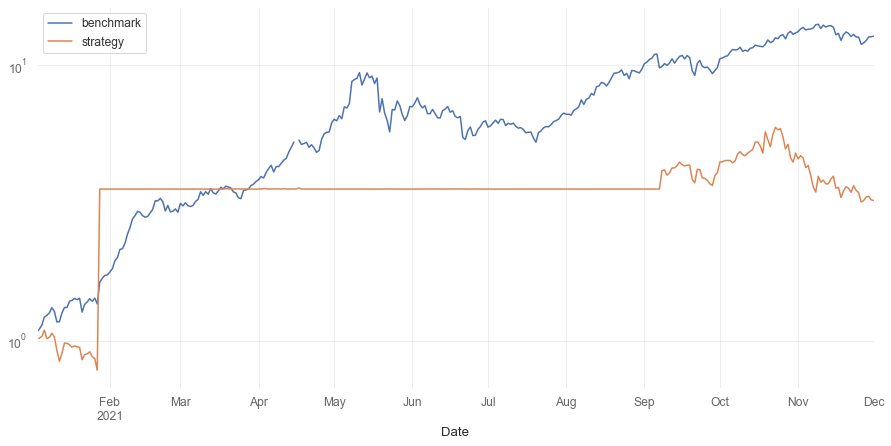

In [11]:
resume_changes = pd.DataFrame(index=strategy.Date)
resume_changes['benchmark'] = benchmark[1:]
resume_changes['strategy'] = strategy['pct_change'].values
cumulative_returns = (resume_changes + 1).cumprod()
cumulative_returns.plot(logy=True, grid=True, figsize=(15,7))

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2021-01-03  2021-01-03
End Period                 2021-12-01  2021-12-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          217.03%     1,091.92%
CAGR﹪                     255.56%     1424.83%

Sharpe                     0.81        3.01
Prob. Sharpe Ratio         95.3%       99.95%
Smart Sharpe               0.79        2.92
Sortino                    7.31        4.71
Smart Sortino              7.09        4.57
Sortino/√2                 5.17        3.33
Smart Sortino/√2           5.01        3.23
Omega                      2.4         2.4

Max Drawdown               -46.45%     -44.18%
Longest DD Days            143         102
Volatility (ann.)          313.55%     70.89%
R^2                        0.08        0.08
Information Ratio          0.01        0.01
Calmar                     5.5    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-10-24,2021-11-26,2021-12-01,38,-46.449020,-45.828937
2,2021-01-07,2021-01-27,2021-01-28,21,-28.504536,-22.952701
3,2021-09-16,2021-09-28,2021-10-01,15,-17.804069,-16.543761
4,2021-10-20,2021-10-21,2021-10-23,3,-11.802729,-6.378958
5,2021-10-17,2021-10-18,2021-10-19,2,-8.848717,-3.172863


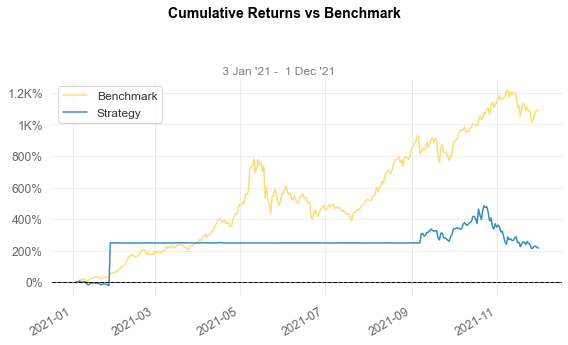

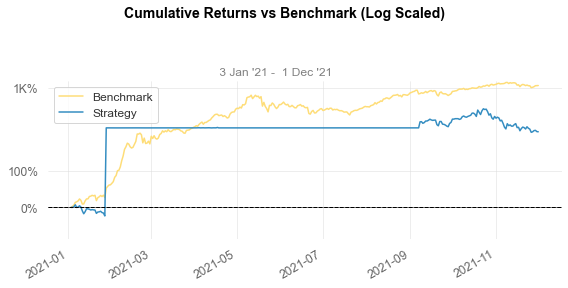

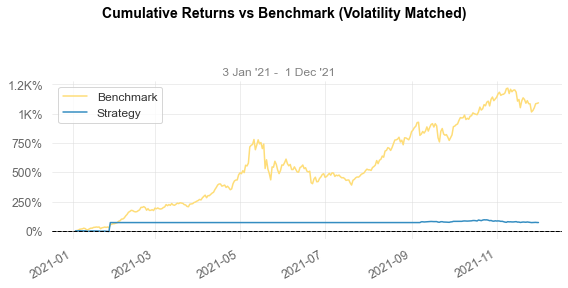

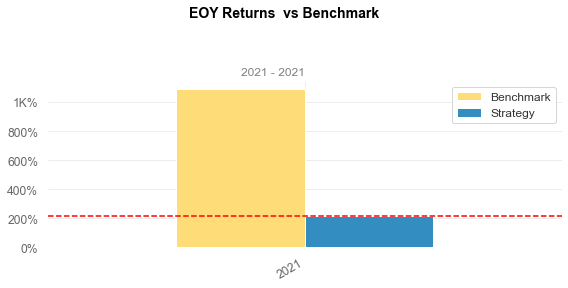

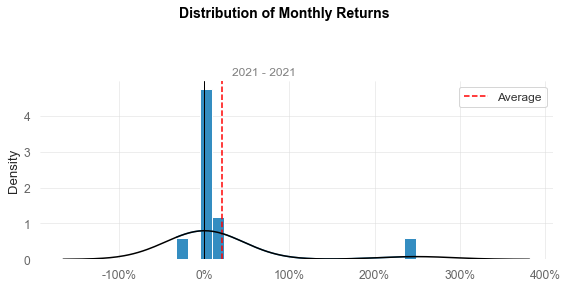

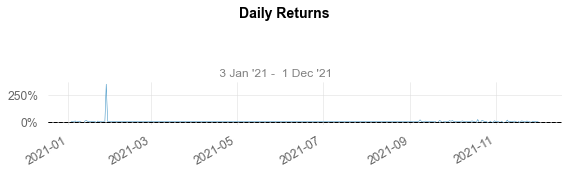

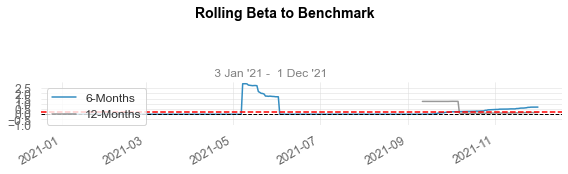

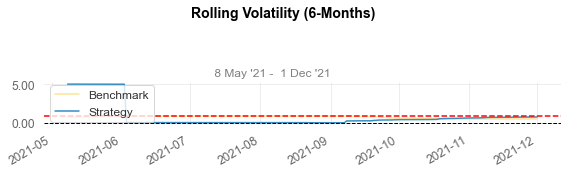

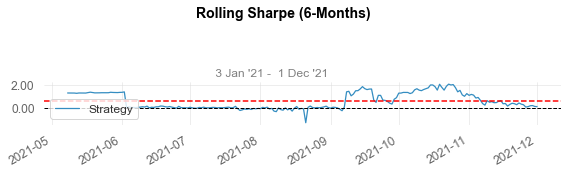

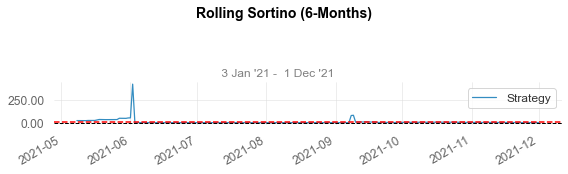

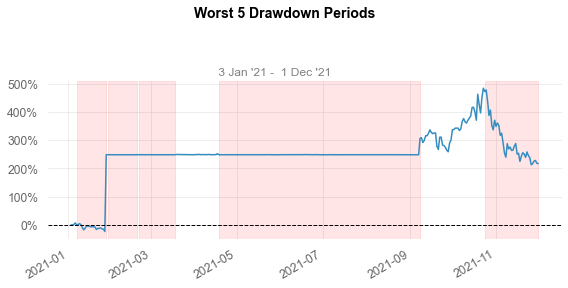

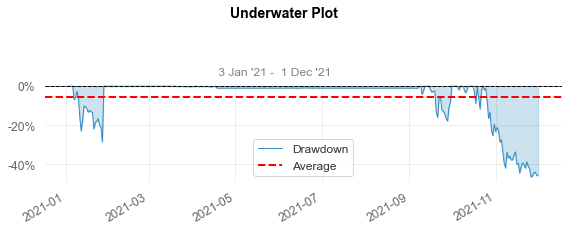

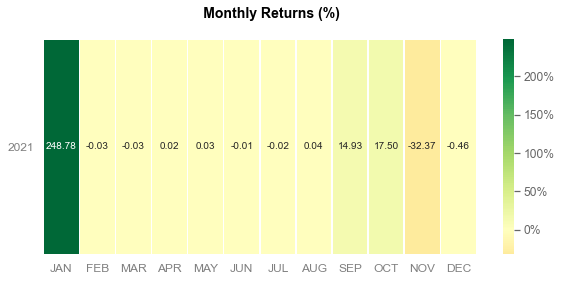

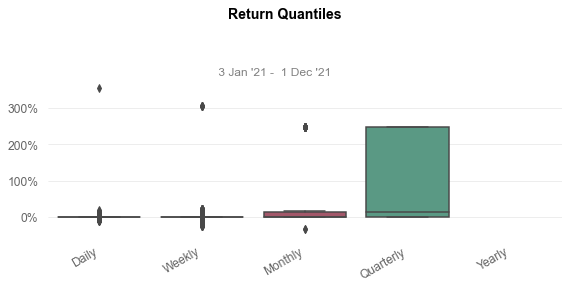

In [12]:
qs.extend_pandas()
qs.reports.full(cumulative_returns['strategy'], cumulative_returns['benchmark'])